# Hyperlattice Queuing Model

### Environment Setup

In [2]:
import sys
import math
import numpy as np

from itertools import combinations, product

### Model

In [3]:
class HyperlatticeQ(object):
    """
    Hyperlattice Queuing Model with Infinite-line Capacity

    A generalized hypercube queuing model, called Hyperlattice, that captures 
    the dynamics of emergency response operations with overlapping patrol. The 
    system state depends on the status of all the servers in this system, and 
    the number of calls in each queue to be processed. These states can be 
    represented by a hyperlattice in dimension I. Each node of the hyperlattice 
    corresponds to a state B = (ni)_{i in set_I} represented by a tuple of 
    numbers, where non-negative integer ni indicates the status of server i. 
    Server i is idle if ni = 0 and busy if ni > 0. The value of ni - 1 
    represents the number of calls waiting in the queue of server i when the 
    server is busy. 
    
    We note that the queuing system in the aggregate is simply a birth-death 
    process whose states are represented by Nk, where k=0,1,...,infinity. This 
    equivalence is obtained by collecting together all states having equal value
    of k = \norm{B}_1. Their summed probability of occurrence is equal to the 
    comparable probability of state occurring in the birth-death model. 
    """

    def __init__(self, I, A, Lam, Eta, mu, K=5, inf=30):
        """
        Params:
        * I:    number of servers (service regions)
        * A:    adjacent matrix that describes the overlappings between service 
                regions. If two regions has an overlapping area, the 
                corresponding entry equals to 1, otherwise 0. 
        * Lam:  arrival rates of each sub-regions, which has the same shape as 
                the adjacent matrix A. The values on the diagonal (i, i)  
                indicate the arrival rates of primary service regions and values 
                on the off-diagonal (i, j) and i != j indicates the arrival 
                rates of overlapping service regions. 
        * Eta:  dispatch probability when both servers are available or busy, 
                which has the same shape as the adjacent matrix A. The value of 
                entry (i, j) represents the probability of assigning call to 
                server i in the overlapping region (i, j). 
                Note that Eta_ij + Eta_ji = 1. 
        * mu:   service rates of each server
        * K:    number of aggregated states to be truncated (estimated)
        * inf:  the maximum length of the queue considered in the model.
                Note that inf >> K is required. 
        """
        # hyperparameters
        self.I = I
        self.K = K
        self.A = A                                                     
        self.n_est_states = sum([ math.comb(I+k-1,I-1) for k in range(K+1) ])   # number of states in the truncated hyperlattice (need to be estimated through solving balance equations)
        self.set_B        = self._tour(K)                                       # set of states in the truncated hyperlattice
        # model parameters
        self.mu     = mu                                                        # service rates
        self.Lam    = Lam                                                       # arrival rates
        self.Eta    = Eta                                                       # dispatch policy
        self.Q      = self._transition_rates()                                  # transition rate matrix
        self.sumLam = np.triu(self.Lam).sum()                                   # sum of arrival rates of the entire service system
        self.aggLam = self._aggregated_arrival_rates(inf + 1)                   # aggregated arrival rates (bar_Lam_k) index mathematically start from 0
        self.aggMu  = np.array([ math.comb(k+I-1, k) * I * mu
                                for k in range(inf + 1) ])                      # aggregated service rates (bar_mu_k)  index mathematically start from 1
        # steady-state distribution
        self.Pi_N   = self._birth_death_solver(inf)                             # steady state probabilities of aggregated states (Nk)
        self.Pi_B   = self._balance_equations_solver()                          # steady state probabilities of states in the truncated hyperlattice (Bu)
        # performance metrics

    def _tour(self, K):
        """
        Tour Algorithm

        The construction of the transition rate matrix requires a complete tour 
        of all the states in the hyperlattice. The tour algorithm generates a 
        complete sequence B_0, B_1, ... of I-digit non-negative integer numbers, 
        with infinite members in the sequence.
        """
        def binary2states(I, bvec):                                             # translate binary combinatorics into state (a vector of non-negative integers)
            B = np.zeros(I)                                                     # initialization of state
            i = 0                                                               # server index
            for b in bvec:
                if b == 1:
                    B[i] += 1                                                   # n_i + 1 if the "ball" is selected
                else:
                    i += 1                                                      # otherwise move to the next ball
            return B

        # initialization
        u     = 0                                                               # state index
        nB    = sum([ math.comb(self.I+k-1,self.I-1) for k in range(K+1) ])     # number of states in the tour
        set_B = np.zeros((nB, self.I))                                          # set of states in the truncated hyperlattice
        # tour starting from N0 to NK
        for k in range(K+1):
            combs = combinations(np.arange(k+self.I-1), k)                      # separate k stars (using I-1 bars) into I groups
            for comb in combs:
                bvec             = np.zeros(k+self.I-1)                         # combinatorics
                bvec[list(comb)] = 1
                set_B[u]         = binary2states(self.I, bvec)                  # state
                u               += 1
        return set_B                                                            # set of all states with shape [ n_est_states, I ]

    def __q(self, Bu, Bv):
        """
        Return the Transition Rate Between State Bu and Bv
        """
        quv  = 0
        dvec = Bu - Bv
        if np.linalg.norm(dvec, ord=1) == 1 and sum(dvec) > 0:                  # downward transition rate
            quv     = self.mu
        elif np.linalg.norm(dvec, ord=1) == 1 and sum(dvec) < 0:                # upward transition rate
            i       = np.where(dvec == -1)[0][0]                                # index of the state becoming busy
            ni0nj0  = [ j                                                       # indices of states j when both i and j are available (ni = nj = 0)
                for j in range(self.I) 
                if self.A[i,j] == 1 and \
                    Bu[i] == 0 and Bu[j] == 0 ]
            ninj    = [ j                                                       # indices of states j when both i and j are busy (ni, nj > 0)
                for j in range(self.I) 
                if self.A[i,j] == 1 and \
                    Bu[i] > 0 and Bu[j] > 0 ]
            ni0nj   = [ j                                                       # indices of states j when i is available and j is busy (ni = 0, nj > 0)
                for j in range(self.I) 
                if self.A[i,j] == 1 and \
                    Bu[i] == 0 and Bu[j] > 0 ]
            quv = self.Lam[i, i] + \
                sum([ self.Eta[i,j] * self.Lam[i,j] for j in ni0nj0 ]) + \
                sum([ self.Eta[i,j] * self.Lam[i,j] for j in ninj ]) + \
                sum([ self.Lam[i,j] for j in ni0nj ])
        else:
            quv = 0.
        return quv
    
    def _transition_rates(self):
        """
        Generate Transition Rate Matrix
        """
        # initialization of transition rate matrix
        Q = np.zeros((self.n_est_states, self.n_est_states))                    
        # fill in off-diagonal entries
        for u in range(self.n_est_states):
            for v in range(self.n_est_states):
                Q[u, v] = self.__q(self.set_B[u], self.set_B[v])                # transition rate between state Bu and Bv
        # fill in diagonal entries
        for u in range(self.n_est_states):
            Q[u, u] = - Q[u, :].sum()                                           # so that each row sums to 0
        return Q                                                                # transition rate matrix with shape [ n_est_states, n_est_states ]

    def _aggregated_arrival_rates(self, inf):
        """
        Arrival Rates for Aggregated States Nk

        TODO:
        Optimize the calculation of aggregated arrival rates. 
        """
        # find state indices for each aggregated group
        ids     = []                                                            
        init_id = 0
        for k in range(inf + 1):
            idk     = np.arange(math.comb(self.I+k-1, self.I-1)) + init_id      # ids[k] gives state indices within the aggregated state k
            init_id = idk[-1] + 1
            ids.append(idk)
        # calculate sum of arrival rates between two consecutive groups
        set_B  = self._tour(inf)                                                # set of all the states 
        aggLam = []
        for k in range(inf):
            agglam = 0
            for uk, uk1 in product(ids[k], ids[k+1]):                           # for a state (uk) from Nk and another state (uk1) from Nk+1
                qukuk1 = self.__q(set_B[uk], set_B[uk1])                        # this step is computationally intensive
                if qukuk1 > 0:
                    agglam += qukuk1
            # print("k=", k)
            # print(np.array([ (set_B[uk], set_B[uk1], self.__q(set_B[uk], set_B[uk1])) for uk, uk1 in product(ids[k], ids[k+1]) ]))
            # print(agglam)
            aggLam.append(agglam)
        return np.array(aggLam)

    def aggregated_arrival_rates_saturated(self, inf):
        """
        Arrival Rates for Aggregated States Nk (Only Between Saturated States)

        This function calculates the sum of all upward transition rates between
        saturated states in Nk and saturated states in Nk+1.

        TODO:
        Optimize the calculation of aggregated arrival rates. 
        """
        set_B   = self._tour(inf)                                               # set of all the states 
        # find state indices for each aggregated group
        ids     = []                                                            
        init_id = 0
        for k in range(inf + 1):
            idk     = np.arange(math.comb(self.I+k-1, self.I-1)) + init_id      # ids[k] gives state indices within the aggregated state k
            idk_sat = [ u for u in idk if sum(set_B[u] > 0) == self.I ]         # ids_sat[k] gives saturated state indices within the aggregated state k
            init_id = idk[-1] + 1
            ids.append(idk_sat)
        # calculate sum of arrival rates between two consecutive groups
        aggLam = []
        for k in range(inf):
            agglam = 0
            for uk, uk1 in product(ids[k], ids[k+1]):                           # for a state (uk) from Nk and another state (uk1) from Nk+1
                qukuk1 = self.__q(set_B[uk], set_B[uk1])                        # this step is computationally intensive
                if qukuk1 > 0:
                    agglam += qukuk1
            aggLam.append(agglam)
        return np.array(aggLam)
    
    def _birth_death_solver(self, inf):
        """
        Birth-Death Model Solver 

        This function calculates steady state probabilities for aggregated 
        states in a birth-death model. 
        """
        C    = np.array([                                                       # C0 = 1
            1 if k == 0 \
            else np.prod([ self.aggLam[n]/self.aggMu[n+1] for n in range(k) ])  # Ck = ( lam_0 * ... * lam_k-1 ) / ( mu_1 * ... * mu_k )
            for k in range(inf) ])
        Pi_N = np.array([                                                       # P0 = 1 / ( sum_k=1^inf Ck )
            1 / C.sum() if k == 0 else C[k] / C.sum()                           # Pk = C_k / ( sum_k=1^inf Ck )
            for k in range(inf) ])
        return Pi_N

    def _balance_equations_solver(self):
        """
        Solve Balance Equations by Matrix Inversion

        This function calculates steady state probabilities for states in the 
        truncated hyperlattice.

        Reference: 
        Constructing and Solving Markov Processes, Section 3.3.2
        https://homepages.inf.ed.ac.uk/jeh/biss2013/Note3.pdf

        TODO: 
        Implement power method to solve balance equations more efficiently, 
        especially when I is large. 
        """
        sum_Pi   = self.Pi_N[:self.K+1].sum()
        Q        = self.Q.copy()                                                # create a copy of transition rate matrix
        Q[:, -1] = np.ones(self.n_est_states)                                   # replace the last column with a vector of 1's
        en       = np.zeros(self.n_est_states)                                  # initialize “solution” vector, which was all zeros to be a column vector with 1 in the last row, and zeros everywhere else
        en[-1]   = sum_Pi
        invQ     = np.linalg.inv(Q.transpose())                                 # inverse of matrix Q
        Pi       = np.matmul(invQ, en)                                          # Pi = (Q^T)^{-1} * en
        return Pi

### Performance Metrics

In [4]:
np.seterr(invalid='ignore')

class HLQperformance(object):
    """
    This class implements a number of key performance measures for a 
    hyperlattice queue model, including individual workloads, fraction of 
    dispatches, and average travel time, etc. 
    """

    def __init__(self, hq, T):
        """
        Params:
        * hq: hyperlattice queue model
        * T:  travel time matrix with shape
        """
        self.hq  = hq
        self.T   = T                                                            # travel time matrix (t_ij represents mean travel time of server i from region i to region (i,j))
        self.rho = self._individual_workloads()                                 # individual workloads for all servers
        self.Rho = self._fraction_of_dispatches()                               # fraction of dispatches for server i in region (i,j)
        self.t   = self._unconditional_mean_travel_time(self.T, self.Rho)       # unconditional mean travel time
        self.t_server = self._mean_server_travel_time(self.T, self.Rho)         # mean travel time of each server
        self.t_region = self._mean_region_travel_time(self.T, self.Rho)

    def _individual_workloads(self):
        """
        Return individual workloads for all servers in the system.
        """
        rho = np.zeros(self.hq.I) 
        for B, pi_B in zip(self.hq.set_B, self.hq.Pi_B):
            for i in range(self.hq.I):
                if B[i] > 0: 
                    rho[i] += pi_B
        return rho
    
    def _fraction_of_dispatches(self):
        """
        Return fraction of dispatches that send a server to each sub-region 
        under its responsibility. The sum of all fractions equals 1.
        """
        Rho = np.zeros((self.hq.I, self.hq.I))
        for i in range(self.hq.I):
            for j in range(self.hq.I):
                if i == j:                                                      # assign i to its primary service region
                    Rho[i,j] = self.hq.Lam[i,j] / self.hq.sumLam
                else:                                                           # assign i to its overlapping service region
                    Rho_ij0 = 0                                                 # assign i to (i,j) randomly
                    Rho_ij1 = 0                                                 # assign i to (i,j) optimally
                    for B, pi_B in zip(self.hq.set_B, self.hq.Pi_B):
                        if B[i] == 0 and B[j] == 0 or B[i] > 0 and B[j] > 0:    # when both i and j are available or both i and j are busy
                            Rho_ij0 += self.hq.Eta[i,j] * self.hq.Lam[i,j] * pi_B   
                        elif B[i] == 0 and B[j] > 0:
                            Rho_ij1 += self.hq.Lam[i,j] * pi_B                  # when i is available and j is busy
                    Rho[i,j] = (Rho_ij0 + Rho_ij1) / self.hq.sumLam
        return Rho
    
    def _unconditional_mean_travel_time(self, T, Rho):
        """
        Return unconditional mean travel time.
        """
        return (self.hq.A * Rho * T).sum()
    
    def _mean_server_travel_time(self, T, Rho):
        """
        Return mean travel time of each server.
        """
        numerator   = (self.hq.A * Rho * T).sum(1)
        denominator = (self.hq.A * Rho).sum(1)
        return numerator / denominator

    def _mean_region_travel_time(self, T, Rho):
        """
        Return mean travel time to overlapping region (i,j).
        """
        i_upper     = np.triu_indices(self.hq.I, k=1)                           # upper triangular matrix indice 
        i_lower     = np.tril_indices(self.hq.I, k=-1)                          # lower triangular matrix indice 
        weighted_T  = Rho * T
        numerator   = np.triu(weighted_T)
        numerator[i_upper] += weighted_T[i_lower]
        denominator = np.triu(Rho)
        denominator[i_upper] += Rho[i_lower]
        t_region    = np.divide(numerator, denominator)
        t_region[np.isnan(t_region)] = 0
        return t_region


### Unit test

In [5]:
# Configuration
A2 = np.array([
    [0, 1],
    [1, 0]
])
Lam2 = np.array([
    [.4, .2], 
    [.2, .4]
])
Eta2 = np.array([
    [0, 0.5],
    [0.5, 0]
])
T2 = np.array([
    [1., 2.5],
    [3., .8]
])

# Unit-test
hq = HyperlatticeQ(I=2, A=A2, Lam=Lam2, Eta=Eta2, mu=5, K=6)
print(hq.Pi_N)
print(hq.Pi_N.sum())
print(hq.Pi_B.sum())

perf = HLQperformance(hq, T2)
print(perf.rho)
print(perf.Rho)
print(perf.Rho.sum())
print(perf.t_region)

[9.49122158e-01 4.74561079e-02 3.16374053e-03 2.37280540e-04
 1.89824432e-05 1.58187026e-06 1.35588880e-07 1.18640270e-08
 1.05458018e-09 9.49122158e-11 8.62838326e-12 7.90935132e-13
 7.30093968e-14 6.77944399e-15 6.32748105e-16 5.93201349e-17
 5.58307152e-18 5.27290088e-19 4.99537978e-20 4.74561079e-21
 4.51962932e-22 4.31419163e-23 4.12661808e-24 3.95467566e-25
 3.79648863e-26 3.65046984e-27 3.51526725e-28 3.38972199e-29
 3.27283503e-30 3.16374053e-31]
0.9999999999999999
0.9999999869769803
[0.09999961 0.09999961]
[[0.4 0.1]
 [0.1 0.4]]
0.9999999973953961
[[1.   2.75]
 [0.   0.8 ]]


# Simulation Model

In [76]:
!pip install -U simpy

import math
import simpy
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Polygon, Point

class SimplePatrolSimulation(object):
    """
    A class that implements a simple patrol scenario where the arrival rate of 
    events is homogeneous over the entire region. 
    """
    def __init__(self, env, region, polices, speed, eta=.5, event_lam=.3, niters=10000):
        self.region           = region
        self.polices          = polices
        self.speed            = speed
        self.event_lam        = event_lam
        self.eta              = eta

        self.waiting_times    = []
        self.travel_times     = []
        self.response_times   = []
        self.service_times    = []
        self.event_locs       = []
        self.assigned_polices = []
        self.Rho              = np.zeros((2, 2))
        self.t_matrix         = np.zeros((2, 2))
        self.n_matrix         = np.zeros((2, 2))

        self.env = env
        self.env.process(self.simulate(polices, event_lam=event_lam))           # simulation
        self.start_time       = self.env.now 
        self.env.run(until=niters)
        self.end_time         = self.env.now 
    
    def _policy(self, event_loc, polices):
        """
        Return the assigned police given the location of the events and all 
        available polices. 
        """
        responsible_polices = [
            police
            for police in polices
            if police['region'].contains(Point(event_loc)) ]                    # the police is responsible for the call if the call is received in the area that the police is in charge of. 

        # police = responsible_polices[
        #     np.argmin([len(police['resource'].queue)                            # choose the police with the shortest queue that belongs to the list of responsible polices. 
        #     for police in responsible_polices ])]
        
        assigned_police_id = 0
        if len(responsible_polices) == 1:
            assigned_police_id = 0
        else:
            # assigned_police_id = random.choice([0, 1])
            assigned_police_id = np.random.binomial(1, self.eta, 1)[0]

        police = responsible_polices[assigned_police_id]
        return police

    def event(self, police, event_loc):
        """
        Simulate an event that requests a police to settle the case. An event 
        will be waiting for an available police to arrive the scene, and take 
        some time (exponential random variable) to settle the case.
        """

        init_time = self.env.now

        with police['resource'].request() as req:                               # wait for police's availability
            yield req 
            disp_time = self.env.now

            distance           = np.sqrt(np.linalg.norm(
                np.array(police['location']) - np.array(event_loc)))            # calculating the distance between police and the event
            # distance           = np.linalg.norm(
            #     np.array(police['location']) - np.array(event_loc))             # calculating the distance between police and the event
            travel_time        = distance / self.speed                          # travel time
            self._update_travel_matrix(event_loc, police, travel_time)          # update travel time matrix
            yield self.env.timeout(travel_time)                                 # wait until the police commute to the location of the event
            police['location'] = event_loc                                      # update police position
            arrv_time          = self.env.now

            service_time       = random.expovariate(police['service_rate'])     # calculating the service duration
            yield self.env.timeout(service_time)                                # wait until the police settle the case
            done_time = self.env.now

            self.assigned_polices.append(police["id"])
            self.waiting_times.append(disp_time - init_time)
            self.response_times.append(arrv_time - init_time)
            self.service_times.append(service_time)
            self.travel_times.append(travel_time)
            self.event_locs.append(event_loc)

    def individual_workloads(self):
        """
        Return individual workloads (rho_i)
        """
        rho = np.zeros(len(self.polices))
        for i in range(len(self.assigned_polices)):
            police_id      = self.assigned_polices[i]
            service_time   = self.service_times[i]
            rho[police_id] += service_time

        rho = rho / (self.end_time - self.start_time)
        return rho

    def simulate(self, polices, event_lam):
        """
        Simulate the process given the available polices as well as the arrival 
        rate of the events and servce rates of the polices.
        """
        for i in itertools.count():
            yield self.env.timeout(random.expovariate(event_lam))               # generate a new event according to event_lam                              
            event_loc = [ 
                random.uniform(
                    self.region[:, 0].min(), self.region[:, 0].max()),
                random.uniform(
                    self.region[:, 1].min(), self.region[:, 1].max()) ]         # generate the random location within the specified polygon for the event
            police = self._policy(event_loc, polices)                           # choose the police to serve the call
            self.env.process(
                self.event(police, event_loc))                                  # simulate the process of the service for this call
    
    def _update_travel_matrix(self, event_loc, police, travel_time):
        """
        Only for two-server system.
        """
        # region where event is received
        if self.polices[0]['region'].contains(Point(event_loc)) and \
           self.polices[1]['region'].contains(Point(event_loc)):
            e_region = -1
        elif self.polices[0]['region'].contains(Point(event_loc)) and \
             not self.polices[1]['region'].contains(Point(event_loc)):
            e_region = 0
        elif not self.polices[0]['region'].contains(Point(event_loc)) and \
             self.polices[1]['region'].contains(Point(event_loc)):
            e_region = 1
        # region where assigned police is located
        if self.polices[0]['region'].contains(Point(police['location'])) and \
           self.polices[1]['region'].contains(Point(police['location'])):
            p_region = -1
        elif self.polices[0]['region'].contains(Point(police['location'])) and \
             not self.polices[1]['region'].contains(Point(police['location'])):
            p_region = 0
        elif not self.polices[0]['region'].contains(Point(police['location'])) and \
             self.polices[1]['region'].contains(Point(police['location'])):
            p_region = 1

        # travel time matrix
        if police['id'] == 0 and e_region == 0 and p_region == 0:
            self.n_matrix[0, 0] += 1
            self.t_matrix[0, 0] += travel_time
        elif police['id'] == 0 and e_region == -1 and p_region == 0:
            self.n_matrix[0, 1] += 1
            self.t_matrix[0, 1] += travel_time
        elif police['id'] == 1 and e_region == 1 and p_region == 1:
            self.n_matrix[1, 1] += 1
            self.t_matrix[1, 1] += travel_time
        elif police['id'] == 1 and e_region == -1 and p_region == 1:
            self.n_matrix[1, 0] += 1
            self.t_matrix[1, 0] += travel_time  

        # call assignment
        if police['id'] == 0 and e_region == 0:
            self.Rho[0, 0] += 1
        elif police['id'] == 0 and e_region == -1:
            self.Rho[0, 1] += 1
        elif police['id'] == 1 and e_region == 1:
            self.Rho[1, 1] += 1
        elif police['id'] == 1 and e_region == -1:
            self.Rho[1, 0] += 1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Experiments


### Synthetic Systems

In [44]:
# A system with two servers
A2 = np.array([
    [0, 1],
    [1, 0]
])
Lam2 = np.array([
    [1., .2], 
    [.2, 1.]
])
Eta2 = np.array([
    [0, 0.5],
    [0.5, 0]
])
T2 = np.array([
    [1., 2.5],
    [3., .8]
])

# A system with three servers
A3 = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])
Lam3a = np.array([
    [1., .1, .1], 
    [.1, 1., .1],
    [.1, .1, 1.]
])
Eta3a = np.array([
    [0, 0.5, 0.5],
    [0.5, 0, 0.5],
    [0.5, 0.5, 0]
])
T3 = np.array([
    [1., 2.5, 3.1],
    [3.3, .8, 1.3],
    [4.1, 2.8, .9]
])

# A system with four servers
A4a = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1], 
    [1, 0, 1, 0]
])
Lam4a = np.array([
    [1., .1, 0, .1], 
    [.1, 1., .1, 0],
    [0, .1, 1., .1],
    [.1, 0, .1, 1.]
])
Eta4a = np.array([
    [0, .5, 0, .5],
    [.5, 0, .5, 0],
    [0, .5, 0, .5],
    [.5, 0, .5, 0]
])
T4 = np.array([
    [1., 2.2, 3.5, 1.9],
    [3.3, .8, 2.3, 2.0],
    [4.1, 2.8, .9, 4.0],
    [2.7, 2.5, 3.2, 1.]
])

def create_2server_system_given_ratio(overlapping_ratio, lam=2):
    """
    """
    # Graph
    A = np.array([
        [0, 1],
        [1, 0]
    ])                                                                          

    # Arrival rate
    lam_o  = lam * overlapping_ratio / 2
    lam_p1 = lam/2 * (1 - overlapping_ratio)
    lam_p2 = lam/2 
    Lam   = np.array([
        [lam_p1, lam_o],
        [lam_o, lam_p2]
    ]) 

    # Dispatch policy
    Eta = np.array([
        [0, 0.5],
        [0.5, 0]
    ])               

    return A, Lam, Eta

def create_2server_system_given_eta(eta, r=.4, lam=2):
    """
    """
    # Graph
    A = np.array([
        [0, 1],
        [1, 0]
    ])       

    # Arrival rate      
    Lam = np.array([
        [lam*(1-r)/2, lam*r], 
        [lam*r, lam*(1-r)/2]
    ])

    # Dispatch policy
    Eta = np.array([
        [0, 1-eta],
        [eta, 0]
    ])             

    return A, Lam, Eta

### Model Estimation

In [8]:
hq2 = HyperlatticeQ(I=2, A=A2, Lam=Lam2, Eta=Eta2, mu=1.1, K=14, inf=20)
hq3 = HyperlatticeQ(I=3, A=A3, Lam=Lam3a, Eta=Eta3a, mu=1.1, K=7, inf=15)
hq4 = HyperlatticeQ(I=4, A=A4a, Lam=Lam4a, Eta=Eta4a, mu=1.1, K=7, inf=10)

perfhq3 = HLQperformance(hq3, T=T3)
perfhq4 = HLQperformance(hq4, T=T4)
print("Rho_ij for an 3-region system:\n", perfhq3.Rho)
print("Sum of Rho_ij:", perfhq3.Rho.sum())
print("Rho_ij for an 4-region system:\n", perfhq4.Rho)
print("Sum of Rho_ij:", perfhq4.Rho.sum())

Rho_ij for an 3-region system:
 [[0.3030303  0.01436588 0.01436588]
 [0.01436588 0.3030303  0.01436588]
 [0.01436588 0.01436588 0.3030303 ]]
Sum of Rho_ij: 0.9952861952861952
Rho_ij for an 4-region system:
 [[0.22727273 0.01128205 0.         0.01128205]
 [0.01128205 0.22727273 0.01128205 0.        ]
 [0.         0.01128205 0.22727273 0.01128205]
 [0.01128205 0.         0.01128205 0.22727273]]
Sum of Rho_ij: 0.9993473193473192


### Visualization

##### Useful functions

In [82]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

def plot_birth_death_rates(hq, inf, ylim=400):
    plt.rc('text', usetex=True)

    font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
    plt.rc('font', **font)
    mpl.rcParams['axes.linewidth'] = 2

    fig, ax = plt.subplots(figsize=(5, 7))
    Lam     = hq.aggLam
    Lam_sat = hq.aggregated_arrival_rates_saturated(inf=inf+1)
    x       = np.arange(len(Lam))
    mu      = hq.aggMu
    approx  = [ (k + hq.I - 1) ** (hq.I - 1) / math.factorial(hq.I - 1) * hq.sumLam for k in x ] 
    ax.plot(x, Lam - Lam_sat, linewidth=2, linestyle='--', c='blue', alpha=0.5, label="non-saturated")
    ax.plot(x, Lam_sat, linewidth=2, linestyle='--', c='red', alpha=0.5, label="saturated")
    ax.plot(x, approx, linewidth=4, linestyle='--', c='green', alpha=0.3, label="Stirling's approximation")
    ax.plot(x, mu, linewidth=4, c='green', label="$\overline{\lambda}_k, \overline{\mu}_{k+1}$")
    # ax.fill_between(x, mu, Lam, where=mu >= Lam, facecolor='green', alpha=0.1, interpolate=True)
    # ax.fill_between(x, mu, Lam, where=mu < Lam, facecolor='red', alpha=0.1, interpolate=True)
    
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('$k$')
    plt.ylabel('Arrival/service rate')
    plt.legend(fontsize=20) # loc='upper left'
    plt.ylim(0, ylim)
    plt.show()

def plot_Q(hq):
    plt.rc('text', usetex=True)

    font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
    plt.rc('font', **font)
    mpl.rcParams['axes.linewidth'] = 2

    cmap = colors.ListedColormap(['white', 'red'])
    bounds=[0, .5, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(hq.Q > 0, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# def plot_avg_travel_time(sim_t, hq_t, x=np.linspace(0., .99, 100)):
#     plt.rc('text', usetex=True)

#     font = {
#         'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 20}
#     plt.rc('font', **font)

#     fig, ax = plt.subplots(figsize=(7, 7))
#     plt.plot(x, sim_t, linewidth=2, linestyle='--', c='blue', alpha=0.5, label="simulation")
#     plt.plot(x, hq_t, linewidth=4, c='red', label="approximation ($\bar{t}^{(i)}$)")
#     plt.xlabel('Overlapping ratio')
#     plt.ylabel('Avg travel time')
#     plt.show()

def plot_rho(sim_rhos, hq_rhos, x=np.linspace(0., .99, 100), xlabel="Overlapping ratio", ylim=[0, .8]):
    plt.rc('text', usetex=True)

    font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
    plt.rc('font', **font)
    mpl.rcParams['axes.linewidth'] = 2

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.plot(x, sim_rhos[:, 0], linewidth=2, linestyle='--', c='red', alpha=0.5, label=r"true $\rho_1$")
    plt.plot(x, sim_rhos[:, 1], linewidth=2, linestyle='--', c='blue', alpha=0.5, label=r"true $\rho_2$")
    plt.plot(x, hq_rhos[:, 0], linewidth=4, c='red', label=r"estimated $\hat{\rho}_1$")
    plt.plot(x, hq_rhos[:, 1], linewidth=4, c='blue', label=r"estimated $\hat{\rho}_2$")
    plt.xlabel(xlabel)
    plt.ylabel('Probability')
    plt.ylim(*ylim)
    plt.legend(fontsize=20) # loc='upper left'
    plt.show()

def plot_Rho(sim_Rhos, hq_Rhos, x=np.linspace(0., .99, 100), xlabel="Overlapping ratio", ylim=[0, .8]):
    plt.rc('text', usetex=True)

    font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
    plt.rc('font', **font)
    mpl.rcParams['axes.linewidth'] = 2

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.plot(x, sim_Rhos[:, 0, 0], linewidth=2, linestyle='--', c='red', alpha=0.5, label=r"true $\rho_{11}$")
    plt.plot(x, sim_Rhos[:, 1, 1], linewidth=2, linestyle='--', c='blue', alpha=0.5, label=r"true $\rho_{22}$")
    plt.plot(x, sim_Rhos[:, 0, 1], linewidth=2, linestyle='--', c='green', alpha=0.5, label=r"true $\rho_{12}$")
    plt.plot(x, sim_Rhos[:, 1, 0], linewidth=2, linestyle='--', c='orange', alpha=0.5, label=r"true $\rho_{21}$")
    plt.plot(x, hq_Rhos[:, 0, 0], linewidth=4, c='red', label=r"estimated $\hat{\rho}_{11}$")
    plt.plot(x, hq_Rhos[:, 1, 1], linewidth=4, c='blue', label=r"estimated $\hat{\rho}_{22}$")
    plt.plot(x, hq_Rhos[:, 0, 1], linewidth=4, c='green', label=r"estimated $\hat{\rho}_{12}$")
    plt.plot(x, hq_Rhos[:, 1, 0], linewidth=4, c='orange', label=r"estimated $\hat{\rho}_{21}$")
    plt.xlabel(xlabel)
    plt.ylabel('Probability')
    plt.ylim(*ylim)
    plt.legend(fontsize=20, ncol=2) # loc='upper left'
    plt.show()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-latex-recommended is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


##### Transition rate matrix

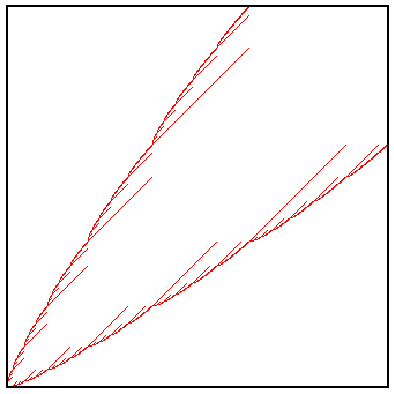

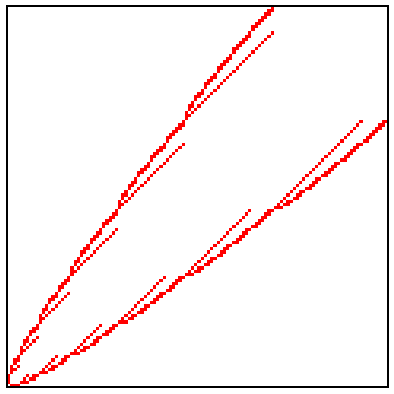

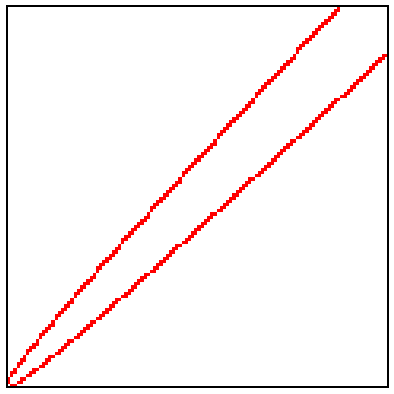

In [74]:
# from numpy import linalg as LA

# for K in range(1, 20):
#     hq = HyperlatticeQ(I=2, A=A2, Lam=Lam2, Eta=Eta2, mu=1.1, K=K, inf=20)
#     w, v = LA.eig((hq.Q > 0) * hq.Q)
#     print("K=", K)
#     plt.plot(w)
#     plt.show()

plot_Q(hq4)
plot_Q(hq3)
plot_Q(hq2)

##### Birth and death rates

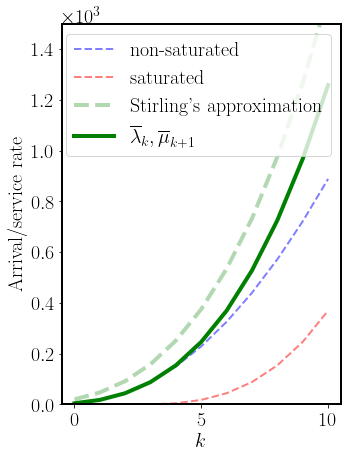

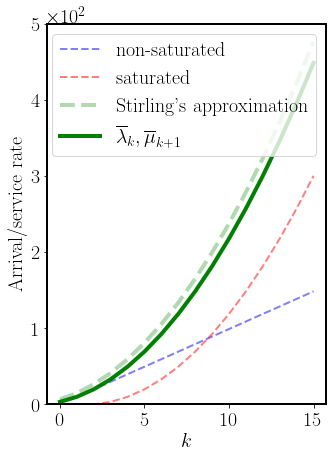

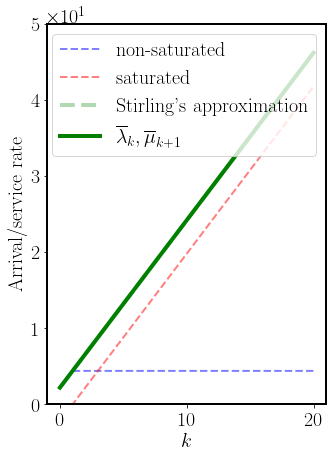

In [75]:
plot_birth_death_rates(hq4, 10, ylim=1500)
plot_birth_death_rates(hq3, 15, ylim=500)
plot_birth_death_rates(hq2, 20, ylim=50)

##### Overlapping ratio analysis

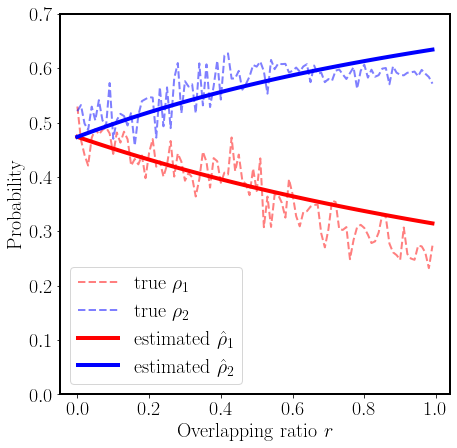

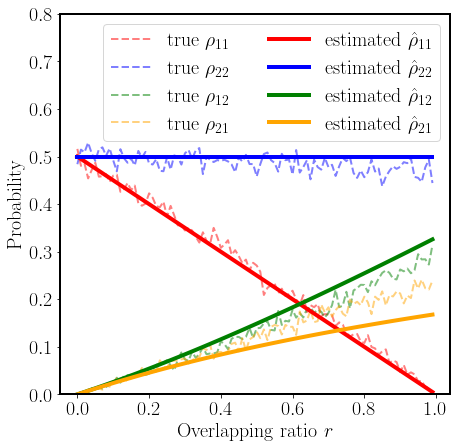

In [85]:
height      = 100.
width       = 100.

sims_over_ratio = []
for overlap_width in tqdm(np.linspace(0., 99., 100)):

    # subr_radius = (width / 2. + overlap_width / 2.) / 2.
    # servers_position   = [(subr_radius, 50.), (100. - subr_radius, 50.)]
    # subregion_polygons = [
    #     [(0., 0.), (2 * subr_radius, 0.),
    #       (2 * subr_radius, height), (0., height)],
    #     [(width - 2 * subr_radius, 0.), (width, 0.),
    #       (width, height), (width - 2 * subr_radius, height)]]

    subr_radius = (width / 2. + overlap_width / 2.) / 2.
    servers_position   = [(subr_radius, 50.), (100. - subr_radius, 50.)]
    subregion_polygons = [
        [(0., 0.), (50, 0.),
         (50, height), (0., height)],
        [(width - 2 * subr_radius, 0.), (width, 0.),
         (width, height), (width - 2 * subr_radius, height)]]

    # Setup and start the simulation
    env = simpy.Environment()
    sim = SimplePatrolSimulation(
        env, 
        region=np.array([(0., 0.), (100., 0.), (100., 100.), (0., 100.)]), 
        polices=[{
            'id':       0,
            'location': servers_position[0],
            'region':   Polygon(subregion_polygons[0]),
            'resource': simpy.Resource(env, capacity=1),
            'service_rate': 1.},
        {
            'id':       1,
            'location': servers_position[1],
            'region':   Polygon(subregion_polygons[1]),
            'resource': simpy.Resource(env, capacity=1),
            'service_rate': 1.}], 
        speed=10., 
        eta=.5,
        event_lam=1, 
        niters=1000)

    sims_over_ratio.append(sim)

# stationary statistics
sim_rhos_r = []
hq_rhos_r  = []
sim_Rhos_r = []
hq_Rhos_r  = []
for overlapping_ratio, sim in zip(np.linspace(0., .99, 100), sims_over_ratio):
    A, Lam, Eta    = create_2server_system_given_ratio(overlapping_ratio, lam=1.)
    T              = sim.t_matrix / sim.n_matrix
    T[np.isnan(T)] = 0
    hq             = HyperlatticeQ(I=2, A=A, Lam=Lam, Eta=Eta, mu=1., K=5, inf=10)
    perf           = HLQperformance(hq, T=T)
    hq_rhos_r.append(perf.rho)
    hq_Rhos_r.append(perf.Rho)
    sim_rhos_r.append(sim.individual_workloads())
    sim_Rhos_r.append(sim.Rho / sim.Rho.sum())
    
sim_rhos_r = np.array(sim_rhos_r)
hq_rhos_r  = np.array(hq_rhos_r)
sim_Rhos_r = np.array(sim_Rhos_r)
hq_Rhos_r  = np.array(hq_Rhos_r)

plot_rho(sim_rhos_r, hq_rhos_r, x=np.linspace(0., .99, 100), xlabel=r"Overlapping ratio $r$", ylim=[0., .7])
plot_Rho(sim_Rhos_r, hq_Rhos_r, x=np.linspace(0., .99, 100), xlabel=r"Overlapping ratio $r$", ylim=[0., .8])

##### Dispatch policy analysis

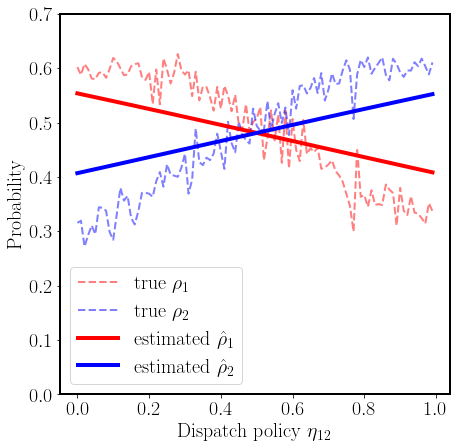

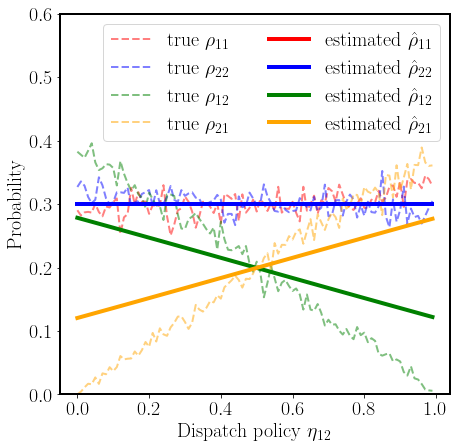

In [88]:
height      = 100.
width       = 100.

sims_over_eta = []
for eta in tqdm(np.linspace(0., .99, 100)):

    servers_position   = [(25., 50.), (75., 50.)]
    subregion_polygons = [
        [(0., 0.), (width*.7, 0.),
         (width*.7, height), (0., height)],
        [(width*.3, 0.), (width, 0.),
         (width, height), (width*.3, height)]]

    # Setup and start the simulation
    env = simpy.Environment()
    sim = SimplePatrolSimulation(
        env, 
        region=np.array([(0., 0.), (100., 0.), (100., 100.), (0., 100.)]), 
        polices=[{
            'id':       0,
            'location': servers_position[0],
            'region':   Polygon(subregion_polygons[0]),
            'resource': simpy.Resource(env, capacity=1),
            'service_rate': 1.},
        {
            'id':       1,
            'location': servers_position[1],
            'region':   Polygon(subregion_polygons[1]),
            'resource': simpy.Resource(env, capacity=1),
            'service_rate': 1.}], 
        speed=10., 
        eta=eta,
        event_lam=1., 
        niters=1000)
    
    sims_over_eta.append(sim)

# stationary statistics
sim_rhos_eta = []
hq_rhos_eta  = []
sim_Rhos_eta = []
hq_Rhos_eta  = []
for eta, sim in zip(np.linspace(0., .99, 100), sims_over_eta):
    A, Lam, Eta    = create_2server_system_given_eta(eta, r=.4, lam=1.)
    T              = sim.t_matrix / sim.n_matrix
    T[np.isnan(T)] = 0
    hq             = HyperlatticeQ(I=2, A=A, Lam=Lam, Eta=Eta, mu=1., K=5, inf=10)
    perf           = HLQperformance(hq, T=T)
    hq_rhos_eta.append(perf.rho)
    hq_Rhos_eta.append(perf.Rho)
    sim_rhos_eta.append(sim.individual_workloads())
    sim_Rhos_eta.append(sim.Rho / sim.Rho.sum())
    
sim_rhos_eta = np.array(sim_rhos_eta)
hq_rhos_eta  = np.array(hq_rhos_eta)
sim_Rhos_eta = np.array(sim_Rhos_eta)
hq_Rhos_eta  = np.array(hq_Rhos_eta)

plot_rho(sim_rhos_eta, hq_rhos_eta, x=np.linspace(0., .99, 100), xlabel=r"Dispatch policy $\eta_{12}$", ylim=[0, .7])
plot_Rho(sim_Rhos_eta, hq_Rhos_eta, x=np.linspace(0., .99, 100), xlabel=r"Dispatch policy $\eta_{12}$", ylim=[0, .6])